In [540]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()


df = pd.read_csv('sickness_table.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
df = df.drop(['Unnamed: 0', 'n_sby', 'dafted'], axis=1)  

df_calls = pd.DataFrame({'calls': df['calls'].values}, index=df.index)

def create_features(dtf) :
    """
    Create time series features from the time index.
    :param dtf: dataframe
    :return:dataframe
    """
    dtf = dtf.copy()
    dtf['dayofweek'] = dtf.index.dayofweek
    dtf['month'] = dtf.index.month
    dtf['year'] = dtf.index.year
    dtf['dayofyear'] = dtf.index.dayofyear
    dtf['dayofmonth'] = dtf.index.day
    dtf['weekofyear'] = dtf.index.isocalendar().week
    dtf['quarter'] = dtf.index.quarter
    return dtf

def add_lags_for_calls(dtf):
    target_map = dtf['calls'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf
df_calls = create_features(df_calls)
df_calls = add_lags_for_calls(df_calls)

In [541]:
df_calls

,calls,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,quarter,lag1,lag2,lag3
date,,,,,,,,,,,
2016-04-01,8154.0,4,4,2016,92,1,13,2,NaN,NaN,NaN
2016-04-02,8526.0,5,4,2016,93,2,13,2,NaN,NaN,NaN
2016-04-03,8088.0,6,4,2016,94,3,13,2,NaN,NaN,NaN
2016-04-04,7044.0,0,4,2016,95,4,14,2,NaN,NaN,NaN
2016-04-05,7236.0,1,4,2016,96,5,14,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-23,8544.0,3,5,2019,143,23,21,2,8814.0,6750.0,8124.0
2019-05-24,8814.0,4,5,2019,144,24,21,2,7572.0,7062.0,6084.0
2019-05-25,9846.0,5,5,2019,145,25,21,2,8136.0,7290.0,6174.0


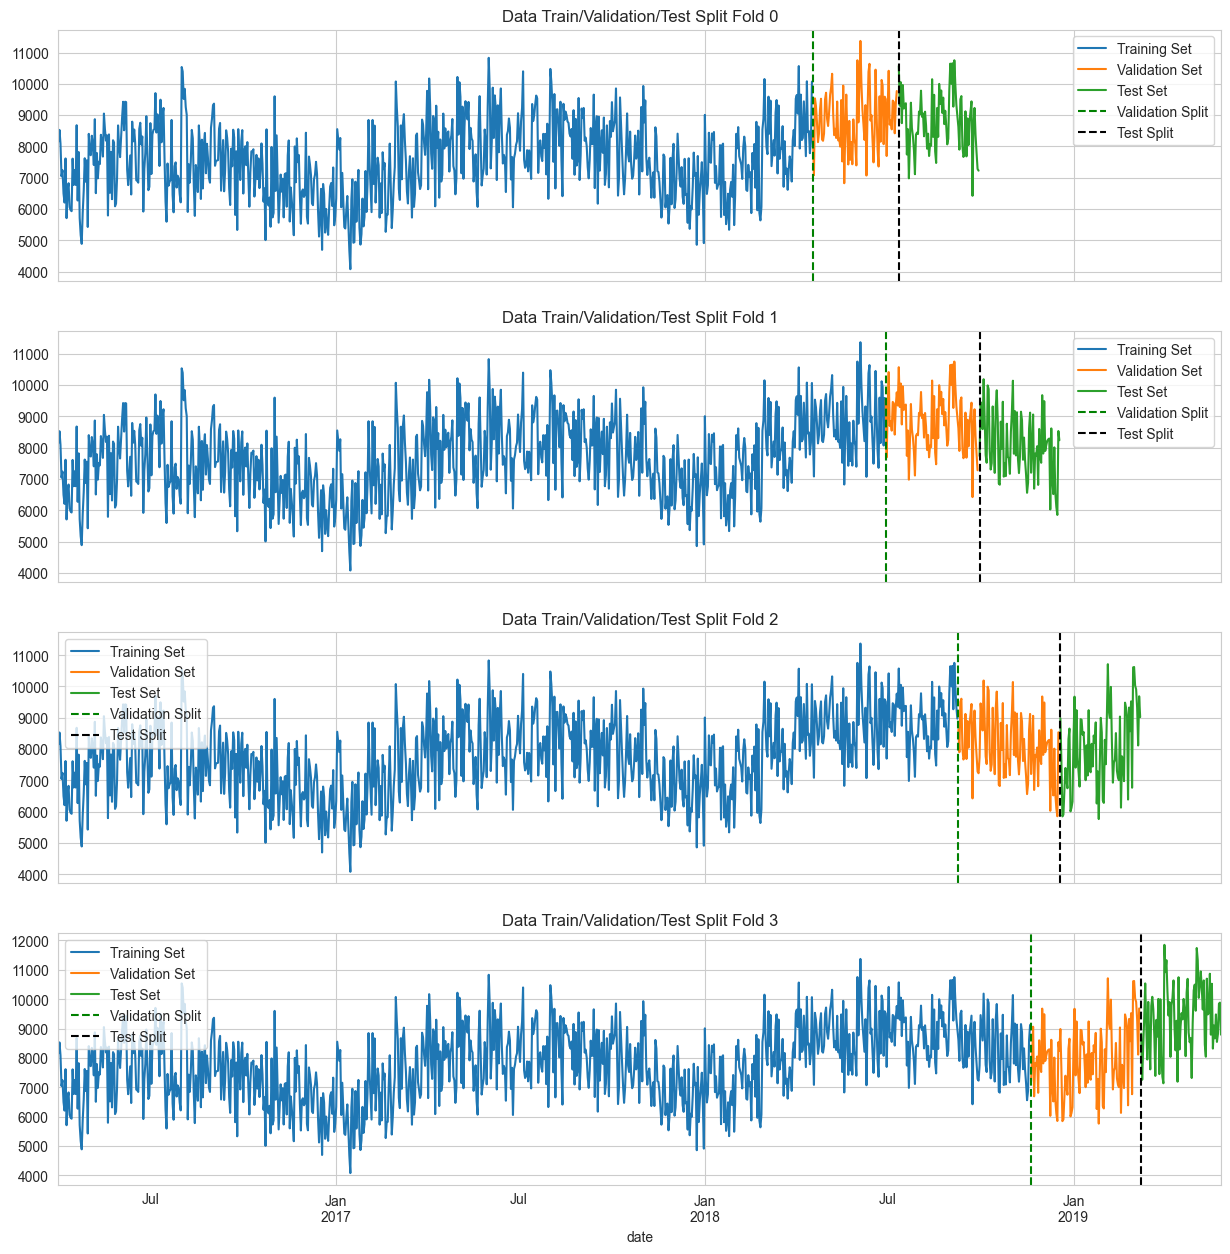

In [542]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

tss = TimeSeriesSplit(n_splits=4, test_size=80, gap=1)
df_calls = df_calls.sort_index()
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)
fig.set_facecolor('white')

fold = 0
for train_idx, test_idx in tss.split(df_calls):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.3, shuffle=False)
    train = df_calls.iloc[train_idx]
    val = df_calls.iloc[val_idx]
    test = df_calls.iloc[test_idx]

    train['calls'].plot(ax=axs[fold],
                           label='Training Set',
                           title=f'Data Train/Validation/Test Split Fold {fold}')
    val['calls'].plot(ax=axs[fold],
                         label='Validation Set')
    test['calls'].plot(ax=axs[fold],
                          label='Test Set')

    axs[fold].axvline(val.index.min(), color='green', ls='--', label='Validation Split')
    axs[fold].axvline(test.index.min(), color='black', ls='--', label='Test Split')
    axs[fold].set_facecolor('white')
    axs[fold].legend()
    if fold == 3 or fold==2:
        axs[fold].legend(loc='upper left')
    fold += 1
plt.savefig("Cross Validation - 4 folds.png", facecolor=fig.get_facecolor(), edgecolor='none')
plt.show()


In [622]:
import numpy as np

def custom_loss(y_true, y_pred):

    difference = y_true - y_pred
    penalized_difference = np.where(difference < 0, 2 * difference, difference)
    loss = np.mean(np.square(penalized_difference))
    return loss


In [628]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np


tss = TimeSeriesSplit(n_splits=4, test_size=80, gap=3)
df_calls = df_calls.sort_index()

fold = 0
preds = []
scores = []

for train_idx, test_idx in tss.split(df_calls):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.4, shuffle=False)

    train = df_calls.iloc[train_idx]
    val = df_calls.iloc[val_idx]
    test = df_calls.iloc[test_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']
    TARGET = ['calls']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    scaler_calls = MinMaxScaler()
    scalar = MinMaxScaler()
    columns = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']
    y_train['calls'] = scaler_calls.fit_transform(y_train['calls'].values.reshape(-1, 1))
    y_val['calls'] = scaler_calls.transform(y_val['calls'].values.reshape(-1, 1))
    y_test['calls'] = scaler_calls.transform(y_test['calls'].values.reshape(-1, 1))

    X_train[columns] = scalar.fit_transform(X_train[columns])
    X_test[columns] = scalar.transform(X_test[columns])
    X_val[columns] = scalar.transform(X_val[columns])
    reg_calls = xgb.XGBRegressor(objective='reg:squarederror')

    # Define the hyperparameter search space
    param_dist = {
        'n_estimators': randint(100, 2000),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.1),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    random_search = RandomizedSearchCV(reg_calls, param_distributions=param_dist, n_iter=50,
                                       scoring='neg_mean_squared_error', cv=5,
                                       n_jobs=-1, verbose=2, random_state=62)
    random_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50,
                      verbose=2)


    best_reg_calls = random_search.best_estimator_

    y_pred = best_reg_calls.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    fold += 1



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:7490.97041
[2]	validation_0-rmse:6565.40363
[4]	validation_0-rmse:5760.24896
[6]	validation_0-rmse:5023.91806
[8]	validation_0-rmse:4389.74748
[10]	validation_0-rmse:3843.57026
[12]	validation_0-rmse:3361.02654
[14]	validation_0-rmse:2981.95548
[16]	validation_0-rmse:2634.36157
[18]	validation_0-rmse:2360.74512
[20]	validation_0-rmse:2117.78182
[22]	validation_0-rmse:1920.14360
[24]	validation_0-rmse:1760.16175
[26]	validation_0-rmse:1619.15469
[28]	validation_0-rmse:1498.64258
[30]	validation_0-rmse:1403.26277
[32]	validation_0-rmse:1328.89406
[34]	validation_0-rmse:1269.61957
[36]	validation_0-rmse:1217.77538
[38]	validation_0-rmse:1179.69802
[40]	validation_0-rmse:1147.96352


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-rmse:1119.54100
[44]	validation_0-rmse:1098.69754
[46]	validation_0-rmse:1083.67263
[48]	validation_0-rmse:1071.11109
[50]	validation_0-rmse:1063.62335
[52]	validation_0-rmse:1054.69479
[54]	validation_0-rmse:1050.31821
[56]	validation_0-rmse:1046.46962
[58]	validation_0-rmse:1043.03321
[60]	validation_0-rmse:1042.67624
[62]	validation_0-rmse:1040.09001
[64]	validation_0-rmse:1038.13312
[66]	validation_0-rmse:1037.57974
[68]	validation_0-rmse:1038.89083
[70]	validation_0-rmse:1038.41871
[72]	validation_0-rmse:1037.36028
[74]	validation_0-rmse:1038.94026
[76]	validation_0-rmse:1040.13880
[78]	validation_0-rmse:1043.98448
[80]	validation_0-rmse:1045.99686
[82]	validation_0-rmse:1047.97264
[84]	validation_0-rmse:1048.09057
[86]	validation_0-rmse:1050.30218
[88]	validation_0-rmse:1050.44290
[90]	validation_0-rmse:1051.87826
[92]	validation_0-rmse:1052.02457
[94]	validation_0-rmse:1052.73688
[96]	validation_0-rmse:1053.85630
[98]	validation_0-rmse:1053.97060
[100]	validati

C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[70]	validation_0-rmse:1179.02814
[72]	validation_0-rmse:1166.89655
[74]	validation_0-rmse:1155.85359
[76]	validation_0-rmse:1147.14590
[78]	validation_0-rmse:1138.59830
[80]	validation_0-rmse:1133.28298
[82]	validation_0-rmse:1127.86970
[84]	validation_0-rmse:1123.84941
[86]	validation_0-rmse:1117.47349
[88]	validation_0-rmse:1114.48892
[90]	validation_0-rmse:1111.66699
[92]	validation_0-rmse:1109.36022
[94]	validation_0-rmse:1106.14923
[96]	validation_0-rmse:1104.19212
[98]	validation_0-rmse:1100.70193
[100]	validation_0-rmse:1099.31825
[102]	validation_0-rmse:1097.70918
[104]	validation_0-rmse:1095.92571
[106]	validation_0-rmse:1093.62436
[108]	validation_0-rmse:1091.80269
[110]	validation_0-rmse:1090.66035
[112]	validation_0-rmse:1088.86659
[114]	validation_0-rmse:1089.42130
[116]	validation_0-rmse:1089.83574
[118]	validation_0-rmse:1089.08206
[120]	validation_0-rmse:1088.76785
[122]	validation_0-rmse:1088.41903
[124]	validation_0-rmse:1089.45132
[126]	validation_0-rmse:1089.34890


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[86]	validation_0-rmse:1055.93910
[88]	validation_0-rmse:1053.33903
[90]	validation_0-rmse:1051.75322
[92]	validation_0-rmse:1050.75958
[94]	validation_0-rmse:1049.71003
[96]	validation_0-rmse:1050.55369
[98]	validation_0-rmse:1048.73627
[100]	validation_0-rmse:1048.33992
[102]	validation_0-rmse:1046.92429
[104]	validation_0-rmse:1047.18343
[106]	validation_0-rmse:1046.63045
[108]	validation_0-rmse:1047.68013
[110]	validation_0-rmse:1047.47085
[112]	validation_0-rmse:1047.42347
[114]	validation_0-rmse:1048.41383
[116]	validation_0-rmse:1048.45580
[118]	validation_0-rmse:1047.70525
[120]	validation_0-rmse:1048.06062
[122]	validation_0-rmse:1047.92101
[124]	validation_0-rmse:1048.38403
[126]	validation_0-rmse:1048.73186
[128]	validation_0-rmse:1049.80530
[130]	validation_0-rmse:1049.87418
[132]	validation_0-rmse:1051.08974
[134]	validation_0-rmse:1050.28226
[136]	validation_0-rmse:1051.50411
[138]	validation_0-rmse:1053.08215
[140]	validation_0-rmse:1053.83262
[142]	validation_0-rmse:105

C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[90]	validation_0-rmse:1143.14840
[92]	validation_0-rmse:1141.72675
[94]	validation_0-rmse:1139.58275
[96]	validation_0-rmse:1137.88922
[98]	validation_0-rmse:1137.88367
[100]	validation_0-rmse:1136.19104
[102]	validation_0-rmse:1134.73440
[104]	validation_0-rmse:1133.71845
[106]	validation_0-rmse:1133.81458
[108]	validation_0-rmse:1131.17366
[110]	validation_0-rmse:1131.10639
[112]	validation_0-rmse:1130.36212
[114]	validation_0-rmse:1131.40086
[116]	validation_0-rmse:1130.46140
[118]	validation_0-rmse:1129.66347
[120]	validation_0-rmse:1130.01462
[122]	validation_0-rmse:1130.21064
[124]	validation_0-rmse:1130.25287
[126]	validation_0-rmse:1130.39359
[128]	validation_0-rmse:1131.05837
[130]	validation_0-rmse:1129.63572
[132]	validation_0-rmse:1130.40042
[134]	validation_0-rmse:1130.16164
[136]	validation_0-rmse:1130.50406
[138]	validation_0-rmse:1132.47365
[140]	validation_0-rmse:1131.76530
[142]	validation_0-rmse:1132.98711
[144]	validation_0-rmse:1132.77467
[146]	validation_0-rmse:1

In [629]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1250.7962
Fold scores:[1102.0576044331542, 1140.6517748022911, 1221.223591926808, 1539.2516587105413]


In [637]:
y_pred

array([8217.421 , 7527.107 , 8024.0312, 8210.558 , 8672.921 , 7947.6855,
       8222.825 , 8111.758 , 7400.6763, 8325.067 , 8557.057 , 8192.329 ,
       8358.813 , 8175.0244, 7882.5566, 7355.975 , 8711.467 , 8699.997 ,
       8743.827 , 8492.122 , 8538.951 , 8049.0913, 8003.7476, 8806.204 ,
       8077.54  , 8468.324 , 8528.903 , 8906.841 , 8050.371 , 7445.2773,
       7990.6865, 8157.0815, 8493.938 , 8914.133 , 8171.5737, 8066.9907,
       7238.902 , 8110.103 , 9025.921 , 8206.561 , 8140.051 , 8531.534 ,
       7642.252 , 7406.0405, 8110.103 , 8050.725 , 7664.6094, 8432.47  ,
       8048.5967, 7695.4375, 7244.75  , 8400.383 , 8919.564 , 8581.44  ,
       8543.27  , 8133.006 , 8865.553 , 8665.098 , 9244.724 , 8144.591 ,
       8515.245 , 8420.484 , 8412.917 , 8134.646 , 7966.7095, 8493.291 ,
       8312.542 , 8334.845 , 8406.541 , 9217.971 , 7967.1885, 7970.1504,
       9160.254 , 8381.895 , 8638.865 , 8322.836 , 8147.606 , 8013.757 ,
       7736.5337, 8394.9375], dtype=float32)

In [638]:
y_pred_original_scale = y_pred
y_pred_original_scale = scaler_calls.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler_calls.inverse_transform(y_test)

y_pred_df = pd.DataFrame(y_pred_original_scale)
y_pred_df['predictions'] = y_pred_df[0]
df2=y_pred_df.drop(y_pred_df.columns[0], axis=1)
test_df_calls = pd.DataFrame(y_test)
test_df_calls['calls'] = test_df_calls[0]
df3=test_df_calls.drop(test_df_calls.columns[0], axis=1)
predictions_calls = pd.concat([df3, df2.set_index(test_df_calls.index)], axis=1)
predictions_calls.index=df_calls.index[-len(y_test):]

# absolute percentage error
predictions_calls['absolute_percentage_error'] = np.abs(predictions_calls['calls'] - predictions_calls['predictions']) / predictions_calls['calls']
mae_calls = np.mean(np.abs(predictions_calls['calls'] - predictions_calls['predictions']))
# mean absolute percentage error
mape = predictions_calls['absolute_percentage_error'].mean() * 100
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Mean Absolute  Error (MAE):', mae_calls)

In [641]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(predictions_calls['calls'], predictions_calls['predictions'])

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Calculate the R-squared score
r2 = r2_score(predictions_calls['calls'], predictions_calls['predictions'])

# Calculate the absolute percentage error for each row
predictions_calls['absolute_percentage_error'] = np.abs(predictions_calls['calls'] - predictions_calls['predictions']) / predictions_calls['calls']

# Calculate the mean absolute percentage error
mape = predictions_calls['absolute_percentage_error'].mean() * 100

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared Score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)


Mean Squared Error (MSE): 2369295.668843153
Root Mean Squared Error (RMSE): 1539.2516587105413
R-squared Score: -0.8709161619248749
Mean Absolute Percentage Error (MAPE): 12.734010377975968


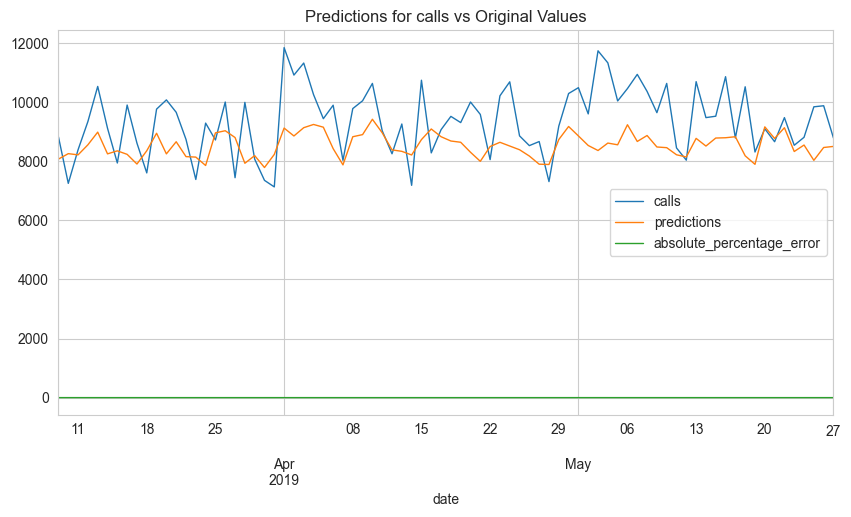

In [551]:
predictions_calls.plot(figsize=(10, 5),
                       color=color_pal,
                       ms=1,
                       lw=1,
                       title='Predictions for calls vs Original Values')

plt.savefig('Predictions for calls.png')
plt.show()

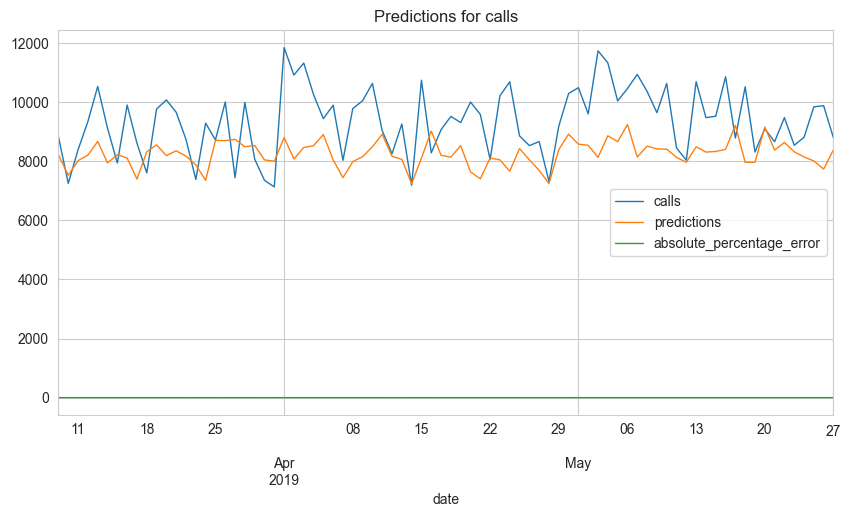

In [642]:
predictions_calls.plot(figsize=(10, 5),
                       color=color_pal,
                       ms=1,
                       lw=1,
                       title='Predictions for calls')
plt.show()

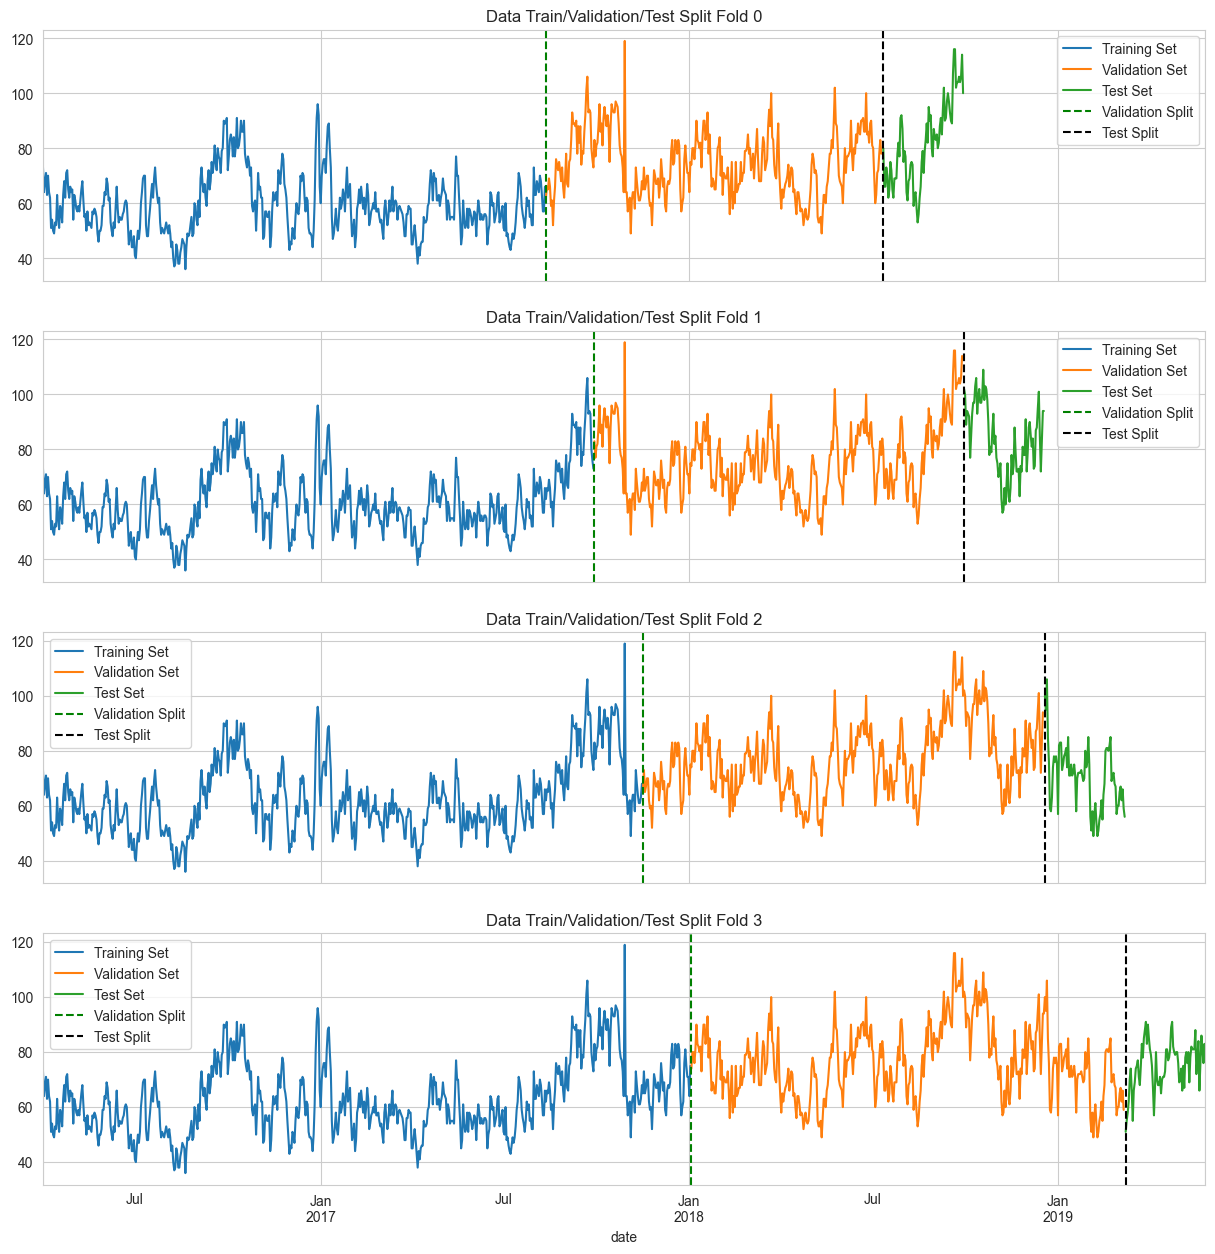

In [552]:
df_sick = pd.DataFrame({'n_sick': df['n_sick'].values}, index=df.index)

tss = TimeSeriesSplit(n_splits=4, test_size=80, gap=1)
df_sick = df_sick.sort_index()
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)
fig.set_facecolor('white')

fold = 0
for train_idx, test_idx in tss.split(df_sick):
    # Split the training set from TimeSeriesSplit into train and validation sets
    train_idx, val_idx = train_test_split(train_idx, test_size=0.3, shuffle=False)

    train = df_sick.iloc[train_idx]
    val = df_sick.iloc[val_idx]
    test = df_sick.iloc[test_idx]

    train['n_sick'].plot(ax=axs[fold],
                        label='Training Set',
                        title=f'Data Train/Validation/Test Split Fold {fold}')
    val['n_sick'].plot(ax=axs[fold],
                      label='Validation Set')
    test['n_sick'].plot(ax=axs[fold],
                       label='Test Set')

    axs[fold].axvline(val.index.min(), color='green', ls='--', label='Validation Split')
    axs[fold].axvline(test.index.min(), color='black', ls='--', label='Test Split')
    axs[fold].set_facecolor('white')
    axs[fold].legend()
    if fold == 3 or fold==2:
        axs[fold].legend(loc='upper left')
    fold += 1
plt.show()


In [553]:
df_sick_1 = create_features(df_sick)
def add_lags_sick(dtf):
    target_map = dtf['n_sick'].to_dict()

    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

df_sick = add_lags_sick(df_sick_1)


In [554]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# NEW CODE
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits=4, test_size=80, gap=1)
df_sick = df_sick.sort_index()

fold = 0
preds = []
scores = []

for train_idx, test_idx in tss.split(df_sick):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.3, shuffle=False)

    train_sick = df_sick.iloc[train_idx]
    val_sick = df_sick.iloc[val_idx]
    test_sick = df_sick.iloc[test_idx]

    train_sick = create_features(train_sick)
    test_sick = create_features(test_sick)

    FEATURES = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']
    TARGET = ['n_sick']

    X_train_sick = train_sick[FEATURES]
    y_train_sick = train_sick[TARGET]

    X_val_sick = val_sick[FEATURES]
    y_val_sick = val_sick[TARGET]

    X_test_sick = test_sick[FEATURES]
    y_test_sick = test_sick[TARGET]

    scaler_sick = MinMaxScaler()
    y_train_sick['n_sick'] = scaler_sick.fit_transform(y_train_sick['n_sick'].values.reshape(-1, 1))
    y_val_sick['n_sick'] = scaler_sick.transform(y_val_sick['n_sick'].values.reshape(-1, 1))
    y_test_sick['n_sick'] = scaler_sick.transform(y_test_sick['n_sick'].values.reshape(-1, 1))

    reg_sick = xgb.XGBRegressor(objective='reg:squarederror')


    param_dist = {
        'n_estimators': randint(100, 2000),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.1),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    random_search = RandomizedSearchCV(reg_sick, param_distributions=param_dist, n_iter=50,
                                       scoring='neg_mean_squared_error', cv=5,
                                       n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train_sick, y_train_sick, eval_set=[(X_val_sick, y_val_sick)], early_stopping_rounds=50,
                      verbose=100)


    best_reg_sick = random_search.best_estimator_

    y_pred_sick = best_reg_sick.predict(X_test_sick)
    preds.append(y_pred_sick)
    score = np.sqrt(mean_squared_error(y_test_sick, y_pred_sick))
    scores.append(score)

    fold += 1




C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_sick['n_sick'] = scaler_sick.fit_transform(y_train_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val_sick['n_sick'] = scaler_sick.transform(y_val_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:43: SettingWithCopyWarning: 
A value 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:0.13325
[53]	validation_0-rmse:0.23215


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits

C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_sick['n_sick'] = scaler_sick.fit_transform(y_train_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val_sick['n_sick'] = scaler_sick.transform(y_val_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:43: SettingWithCopyWarning: 
A value 


[0]	validation_0-rmse:0.14977
[59]	validation_0-rmse:0.18716


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_sick['n_sick'] = scaler_sick.fit_transform(y_train_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:0.16021
[56]	validation_0-rmse:0.20742


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_sick['n_sick'] = scaler_sick.fit_transform(y_train_sick['n_sick'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\654659516.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:0.16576
[56]	validation_0-rmse:0.16417


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [555]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.1473
Fold scores:[0.17390435623653167, 0.16070972419071902, 0.13630594196408305, 0.11839454423908402]


In [556]:
y_pred_original_scale_sick = scaler_sick.inverse_transform(y_pred_sick.reshape(-1, 1))
y_test_sick = scaler_sick.inverse_transform(y_test_sick)
y_pred_df_sick = pd.DataFrame(y_pred_original_scale_sick)
y_pred_df_sick['predictions'] = y_pred_df_sick[0]
df2=y_pred_df_sick.drop(y_pred_df_sick.columns[0], axis=1)
test_df = pd.DataFrame(y_test_sick)
test_df['n_sick'] = test_df[0]
df3=test_df.drop(test_df.columns[0], axis=1)
predictions_sick = pd.concat([df3, df2.set_index(test_df.index)], axis=1)
predictions_sick.index=df_sick.index[-len(y_test):]
predictions_sick


In [558]:
#absolute percentage error
predictions_sick['absolute_percentage_error'] = np.abs(predictions_sick['n_sick'] - predictions_sick['predictions']) / predictions_sick['n_sick']

#mean absolute percentage error
mape = predictions_sick['absolute_percentage_error'].mean() * 100
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Percentage Error (MAPE): 11.017281818427993


In [559]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
mse = mean_squared_error(predictions_sick['n_sick'], predictions_sick['predictions'])

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Calculate the R-squared score
r2 = r2_score(predictions_sick['n_sick'], predictions_sick['predictions'])

# Calculate the absolute percentage error for each row
predictions_sick['absolute_percentage_error'] = np.abs(predictions_sick['n_sick'] - predictions_sick['predictions']) / predictions_sick['n_sick']

# Calculate the mean absolute percentage error
mape = predictions_sick['absolute_percentage_error'].mean() * 100

print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared Score:', r2)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 96.56496892561924
Root Mean Squared Error (RMSE): 9.826747627044222
R-squared Score: -0.3549442165837484
Mean Absolute Percentage Error (MAPE): 11.017281818427993


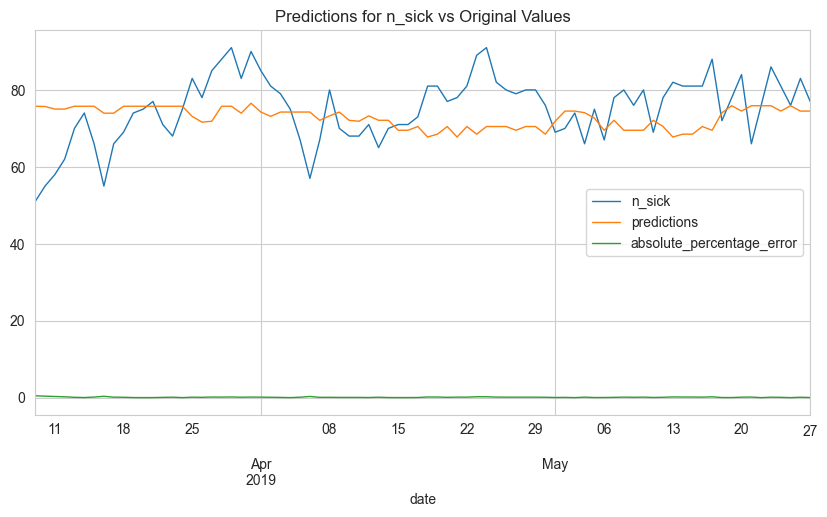

In [560]:
predictions_sick.plot(figsize=(10, 5),
                       color=color_pal,
                       ms=1,
                       lw=1,
                       title='Predictions for n_sick vs Original Values')
plt.savefig('Predictions for n_sick.png')
plt.show()

In [561]:
df_sby = create_features(df)
def add_lags(dtf):
    target_map = dtf['sby_need'].to_dict()

    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

df_sby = add_lags_sick(df_sby)
df_sby

,n_sick,calls,n_duty,sby_need,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,quarter,lag1,lag2,lag3
date,,,,,,,,,,,,,,
2016-04-01,73,8154.0,1700,4.0,4,4,2016,92,1,13,2,NaN,NaN,NaN
2016-04-02,64,8526.0,1700,70.0,5,4,2016,93,2,13,2,NaN,NaN,NaN
2016-04-03,68,8088.0,1700,0.0,6,4,2016,94,3,13,2,NaN,NaN,NaN
2016-04-04,71,7044.0,1700,0.0,0,4,2016,95,4,14,2,NaN,NaN,NaN
2016-04-05,63,7236.0,1700,0.0,1,4,2016,96,5,14,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-23,86,8544.0,1900,0.0,3,5,2019,143,23,21,2,90.0,52.0,46.0
2019-05-24,81,8814.0,1900,0.0,4,5,2019,144,24,21,2,102.0,58.0,50.0
2019-05-25,76,9846.0,1900,146.0,5,5,2019,145,25,21,2,89.0,51.0,50.0


In [562]:
columns_to_scale = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']

# Combine n_sick, calls, and n_duty values to create X_test for sby_need prediction
predictions_sick['predictions']


date
2019-03-09    75.757500
2019-03-10    75.698151
2019-03-11    75.027573
2019-03-12    75.027573
2019-03-13    75.757500
                ...    
2019-05-23    75.887886
2019-05-24    74.500130
2019-05-25    75.887886
2019-05-26    74.500130
2019-05-27    74.500130
Name: predictions, Length: 80, dtype: float32

In [653]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

tss = TimeSeriesSplit(n_splits=4, test_size=80, gap=1)
df_sby = df_sby.sort_index()

fold = 0
preds = []
scores = []

for train_idx, test_idx in tss.split(df_sby):
    train_idx, val_idx = train_test_split(train_idx, test_size=0.5, shuffle=False)

    train_sby = df_sby.iloc[train_idx]
    val_sby = df_sby.iloc[val_idx]
    test_sby = df_sby.iloc[test_idx]

    train_sby = create_features(train_sby)
    test_sby = create_features(test_sby)

    FEATURES = ['calls', 'n_sick','n_duty', 'dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']
    TARGET = ['sby_need']

    X_train_sby = train_sby[FEATURES]
    y_train_sby = train_sby[TARGET]

    X_val_sby = val_sby[FEATURES]
    y_val_sby = val_sby[TARGET]

    X_test_sby = test_sby[FEATURES]
    y_test_sby = test_sby[TARGET]
    scaler_calls = StandardScaler()
    scaler_sick = MinMaxScaler()
    scaler_duty = MinMaxScaler()
    scalar = MinMaxScaler()
    columns_to_scale = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']
    X_train_sby['calls'] = scaler_calls.fit_transform(X_train_sby['calls'].values.reshape(-1, 1))
    X_test_sby['calls'] = scaler_calls.transform(X_test_sby['calls'].values.reshape(-1, 1))
    X_val_sby['calls'] = scaler_calls.transform(X_val_sby['calls'].values.reshape(-1, 1))

    X_train_sby['n_sick'] = scaler_sick.fit_transform(X_train_sby['n_sick'].values.reshape(-1, 1))
    X_test_sby['n_sick'] = scaler_sick.transform(X_test_sby['n_sick'].values.reshape(-1, 1))
    X_val_sby['n_sick'] = scaler_sick.transform(X_val_sby['n_sick'].values.reshape(-1, 1))


    X_train_sby['n_duty'] = scaler_duty.fit_transform(X_train_sby['n_duty'].values.reshape(-1, 1))
    X_test_sby['n_duty'] = scaler_duty.transform(X_test_sby['n_duty'].values.reshape(-1, 1))
    X_val_sby['n_duty'] = scaler_duty.transform(X_val_sby['n_duty'].values.reshape(-1, 1))

    X_train_sby[columns_to_scale] = scalar.fit_transform(X_train_sby[columns_to_scale])
    X_test_sby[columns_to_scale] = scalar.transform(X_test_sby[columns_to_scale])
    X_val_sby[columns_to_scale] = scalar.transform(X_val_sby[columns_to_scale])

    X_test_new = pd.DataFrame({ 'calls': predictions_calls['predictions'],'n_sick': predictions_sick['predictions'], 'n_duty': df.loc[predictions_calls.index, 'n_duty']})

    X_test_new["dayofweek"] = X_test_new.index.dayofweek
    X_test_new["month"] = X_test_new.index.month
    X_test_new["dayofyear"] = X_test_new.index.dayofyear
    X_test_new["quarter"] = X_test_new.index.quarter
    X_test_new["lag1"] = df_sick.loc[X_test_new.index, 'lag1']
    X_test_new["lag2"] = df_sick.loc[X_test_new.index, 'lag2']

    X_test_new['calls'] = scaler_calls.transform(X_test_new['calls'].values.reshape(-1, 1))
    X_test_new['calls'] = X_test_new['calls'] + 1
    X_test_new['n_sick'] = scaler_sick.transform(X_test_new['n_sick'].values.reshape(-1, 1))
    X_test_new['n_duty'] = scaler_duty.transform(X_test_new['n_duty'].values.reshape(-1, 1))
    X_test_new[columns_to_scale] = scalar.transform(X_test_new[columns_to_scale])

    reg_sby = xgb.XGBRegressor(objective='reg:squarederror')

    # Define the hyperparameter search space
    param_dist = {
        'n_estimators': randint(100, 2000),
        'max_depth': randint(3, 8),
        'learning_rate': uniform(0.01, 0.1),
        'colsample_bytree': uniform(0.7, 0.3),
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0, 0.1, 0.5]
    }

    random_search = RandomizedSearchCV(reg_sby, param_distributions=param_dist, n_iter=50,
                                       scoring='neg_mean_squared_error', cv=5,
                                       n_jobs=-1, verbose=2, random_state=42)
    random_search.fit(X_train_sby, y_train_sby, eval_set=[(X_val_sby, y_val_sby)], early_stopping_rounds=50,
                      verbose=100)

    # Get the best estimator from the search
    best_reg_sby = random_search.best_estimator_

    y_pred_sby = best_reg_sby.predict(X_test_new)
    preds.append(y_pred_sby)
    score = np.sqrt(mean_squared_error(y_test_sby, y_pred_sby))
    scores.append(score)

    fold += 1



C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sby['calls'] = scaler_calls.fit_transform(X_train_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sby['calls'] = scaler_calls.transform(X_test_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:46: SettingWithCopyWarning: 
A value i

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:77.32052
[100]	validation_0-rmse:25.60267


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[132]	validation_0-rmse:28.50296


C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sby['calls'] = scaler_calls.fit_transform(X_train_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_sby['calls'] = scaler_calls.transform(X_test_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:46: SettingWithCopyWarning: 
A value i

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:70.15041
[61]	validation_0-rmse:43.05724


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sby['calls'] = scaler_calls.fit_transform(X_train_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:62.72908
[59]	validation_0-rmse:41.86246


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_sby['calls'] = scaler_calls.fit_transform(X_train_sby['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3500129963.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[0]	validation_0-rmse:62.02140
[59]	validation_0-rmse:46.02062


C:\Users\lava2\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [660]:
y_pred_new = pd.DataFrame(y_pred_sby)
y_pred_new['predictions'] = y_pred_new[0]

results_df_new = pd.concat([y_test_sby.reset_index(drop=True), y_pred_new['predictions'].reset_index(drop=True)], axis=1)


results_df_new.plot(figsize=(16, 5),
                color=color_pal,
                ms=1,
                lw=1,
                title='Predictions for sby_need with Predicted values of n_sick and calls')
plt.axhline(y=90, color='black', linestyle='--', label='y=90')
plt.savefig('Predictions for sby_need with Predicted values of n_sick and calls_xgboost.png')
plt.show()


,sby_need
date,
2019-03-09,0.0
2019-03-10,0.0
2019-03-11,0.0
2019-03-12,32.0
2019-03-13,278.0
...,...
2019-05-23,0.0
2019-05-24,0.0
2019-05-25,146.0


In [663]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(results_df_new['sby_need'], results_df_new['predictions'])
print(mae)
mse = mean_squared_error(results_df_new['sby_need'], results_df_new['predictions'])
mse = mse ** 0.5
print(mse)

112.71383475661278

In [651]:
X_test_new

,calls,n_sick,n_duty,dayofweek,month,dayofyear,quarter,lag1,lag2
date,,,,,,,,,
2019-03-09,1.561525,0.662625,2.0,5,3,68,1,76.0,57.0
2019-03-10,0.994175,0.661636,2.0,6,3,69,1,68.0,61.0
2019-03-11,1.402583,0.650460,2.0,0,3,70,1,68.0,66.0
2019-03-12,1.555884,0.650460,2.0,1,3,71,1,68.0,57.0
2019-03-13,1.935888,0.662625,2.0,2,3,72,1,78.0,60.0
...,...,...,...,...,...,...,...,...,...
2019-05-23,1.648163,0.664798,2.0,3,5,143,2,90.0,52.0
2019-05-24,1.504146,0.641669,2.0,4,5,144,2,102.0,58.0
2019-05-25,1.394139,0.664798,2.0,5,5,145,2,89.0,51.0


In [652]:
X_test_sby

,calls,n_sick,n_duty,dayofweek,month,dayofyear,quarter,lag1,lag2
date,,,,,,,,,
2019-03-09,1.061699,0.250000,2.0,5,3,68,1,76.0,57.0
2019-03-10,-0.230284,0.316667,2.0,6,3,69,1,68.0,61.0
2019-03-11,0.706650,0.366667,2.0,0,3,70,1,68.0,66.0
2019-03-12,1.490717,0.433333,2.0,1,3,71,1,68.0,57.0
2019-03-13,2.467101,0.566667,2.0,2,3,72,1,78.0,60.0
...,...,...,...,...,...,...,...,...,...
2019-05-23,0.829931,0.833333,2.0,3,5,143,2,90.0,52.0
2019-05-24,1.051837,0.750000,2.0,4,5,144,2,102.0,58.0
2019-05-25,1.900009,0.666667,2.0,5,5,145,2,89.0,51.0


In [714]:
y_test_sby

,sby_need
date,
2019-03-09,0.0
2019-03-10,0.0
2019-03-11,0.0
2019-03-12,32.0
2019-03-13,278.0
...,...
2019-05-23,0.0
2019-05-24,0.0
2019-05-25,146.0


In [741]:

# Make predictions for the test data
predicted_y =best_reg_sby.predict(X_test_sby)
predicted_y = pd.DataFrame(predicted_y)
predicted_y.index = y_test_sby.index

# Make predictions for the test data
predicted_y_new =best_reg_sby.predict(X_test_new)
predicted_y_new = pd.DataFrame(predicted_y_new)
predicted_y_new.index = y_test_sby.index


In [742]:

# Create a DataFrame with original y and predicted y values
results_df = pd.DataFrame({
    'Original_y': y_test_sby['sby_need'],
    'Predicted_y': predicted_y[0]  # Flatten the predictions array
}, index=y_test_sby.index)

results_df_new = pd.DataFrame({
    'Original_y': y_test_sby['sby_need'],
    'Predicted_y': predicted_y_new[0]  # Flatten the predictions array
}, index=y_test_sby.index)

# Print the DataFrame
print(results_df_new)


            Original_y  Predicted_y
date                               
2019-03-09         0.0   102.879509
2019-03-10         0.0     7.130784
2019-03-11         0.0    73.459175
2019-03-12        32.0    94.634392
2019-03-13       278.0   167.715973
...                ...          ...
2019-05-23         0.0   118.223930
2019-05-24         0.0    98.207420
2019-05-25       146.0    73.459175
2019-05-26       160.0    35.675003
2019-05-27         0.0   129.737091

[80 rows x 2 columns]


In [732]:
comparison_df = pd.DataFrame({
    'Original_y': results_df['Original_y'],
    'Predicted_y': 90
})
comparison_df.index = results_df.index
comparison_df

,Original_y,Predicted_y
date,,
2019-03-09,0.0,90
2019-03-10,0.0,90
2019-03-11,0.0,90
2019-03-12,32.0,90
2019-03-13,278.0,90
...,...,...
2019-05-23,0.0,90
2019-05-24,0.0,90
2019-05-25,146.0,90


In [780]:
# def efficiency_metric(df):
#     activation_rate = activation_rate_metric(df)
#     insufficient_standbys = insufficient_standbys_metric(df)
#
#     activation_weight = 0.3
#     insufficient_weight = 0.7
#
#     efficiency_score = (activation_weight * activation_rate) - (insufficient_weight * insufficient_standbys)
#
#     return efficiency_score
#
def activation_rate_metric(df):
    activation_rate = (np.abs(df['Predicted_y'] - df['Original_y']).mean()*100)/df['Predicted_y'].mean()
    return activation_rate

def insufficient_standbys_metric(df):
    insufficient_standbys = (df['Predicted_y'] < df['Original_y']).mean() * 100
    return 100-insufficient_standbys

def efficiency_metric(df):
    MAPE = activation_rate_metric(df)
    insufficient_standbys = insufficient_standbys_metric(df)

    #  weights
    activation_weight = 0.3
    insufficient_weight = 0.7

    # higher efficiency scores correspond to lower MAPE and insufficiency rates
    inverse_activation_rate = 100 - MAPE
    inverse_insufficient_standbys = 100 - insufficient_standbys

    efficiency_score = (activation_weight * inverse_activation_rate) + (insufficient_weight * inverse_insufficient_standbys)

    return efficiency_score



In [782]:
# artest = activation_rate_metric(results_df)
# intest = insufficient_standbys_metric(results_df)
# ar_new = activation_rate_metric(results_df_new)
# in_new = insufficient_standbys_metric(results_df_new)
# ar_orig = activation_rate_metric(comparison_df)
# in_orig = insufficient_standbys_metric(comparison_df)
# print('Activation rate for test', artest)
# print('Insuff sby rate for test',intest)
# print('Activation rate for pred',ar_new)
# print('Insuff sby rate for pred',in_new)
# print('Activation rate for Original',ar_orig)
# print('Insuff sby rate for Original',in_orig)
# activation_rate_metric(results_df_new)

print(efficiency_metric(comparison_df))
print(efficiency_metric(results_df))
print(efficiency_metric(results_df_new))

39.80555555555556
120.232701637498
60.44137006362617


In [393]:
y_pred_df = pd.DataFrame(y_pred_sby)
y_pred_df['predictions'] = y_pred_df[0]
df2=y_pred_df.drop(y_pred_df.columns[0], axis=1)
test_df = pd.DataFrame(y_test_sby)
predictions_sby = pd.concat([test_df, df2.set_index(test_df.index)], axis=1)
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


predictions_sby

Score across folds 17.2025
Fold scores:[29.648401486353343, 8.955034620017262, 5.362964640286698, 24.84347454812321]


,sby_need,predictions
date,,
2019-03-09,0.0,-5.117242
2019-03-10,0.0,-2.393923
2019-03-11,0.0,-9.169044
2019-03-12,32.0,24.949245
2019-03-13,278.0,272.890747
...,...,...
2019-05-23,0.0,9.861516
2019-05-24,0.0,5.909908
2019-05-25,146.0,163.878021


In [402]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def calculate_mape(y_true, y_pred):

    absolute_percentage_error = np.abs((y_true - y_pred) / (y_true + 4))  # Adding a small value to avoid division by zero
    mape = np.mean(absolute_percentage_error) * 100
    return mape

mape = calculate_mape(predictions_sby['sby_need'], predictions_sby['predictions'])
print("Mean Absolute Percentage Error (MAPE):", mape)

score = np.sqrt(mean_squared_error(predictions_sby['sby_need'], predictions_sby['predictions']))
print(score)
print(mean_absolute_error(predictions_sby['sby_need'], predictions_sby['predictions']))
print(mean_absolute_error(predictions_sick['n_sick'], predictions_sick['predictions']))
print(mean_absolute_error(predictions_calls['calls'], predictions_calls['predictions']))





Mean Absolute Percentage Error (MAPE): 41.05899352781724
24.84347454812321
11.840244416787755
9.239074850082398
1005.3934448242187


In [392]:
predictions_sby['predictions'] = predictions_sby['predictions'].apply(lambda x: 2 * x if x < 20 else x)



Mean Absolute Percentage Error (MAPE): 1398.6358939556449


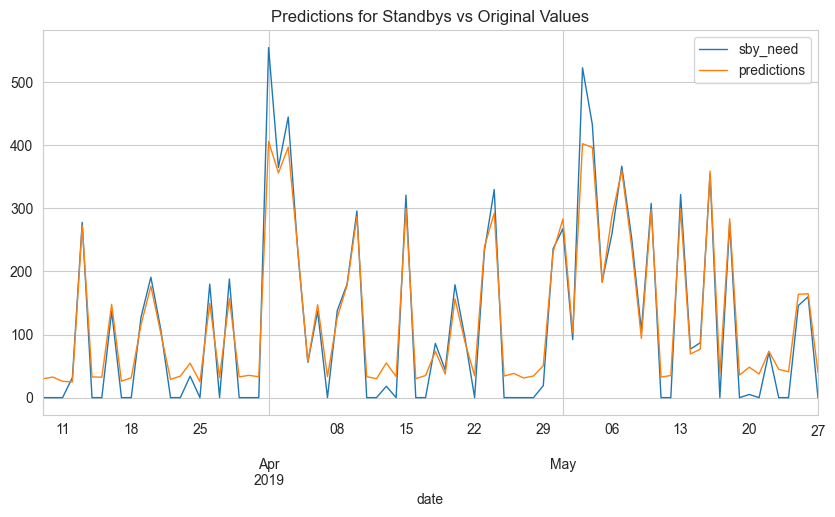

In [368]:
predictions_sby.plot(figsize=(10, 5),
                 color=color_pal,
                 ms=1,
                 lw=1,
                 title='Predictions for Standbys vs Original Values')
plt.savefig('Predictions for Standbys.svg')
plt.show()

In [359]:
future_calls = pd.date_range('2019-06-01','2019-06-30')
FEATURES = ['dayofweek', 'month', 'dayofyear', 'quarter', 'year', 'lag1', 'lag2', 'lag3']
future_df = pd.DataFrame(index=future_calls)
future_df['isFuture'] = True
df_calls['isFuture'] = False
df_and_future = pd.concat([df_calls, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags_for_calls(df_and_future)
future_w_features_calls = df_and_future.query('isFuture').copy()
og= best_reg_calls.predict(future_w_features_calls[FEATURES])
# orig_scale= scaler_calls.inverse_transform(og.reshape(-1, 1))
og_df = pd.DataFrame(og)
og_df.index = future_w_features_calls.index
og_df["calls"]  = og_df[0]
og_df_calls = og_df.drop(og_df.columns[0], axis=1)
og_df_calls


,calls
2019-06-01,9126.811523
2019-06-02,9781.440430
2019-06-03,8450.928711
2019-06-04,9930.257812
2019-06-05,8761.264648
2019-06-06,9748.200195
2019-06-07,8900.592773
2019-06-08,9475.383789
2019-06-09,8574.521484
2019-06-10,9089.215820


In [360]:
future_calls = pd.date_range('2019-06-01','2019-06-30')
FEATURES = ['dayofweek', 'month', 'dayofyear', 'quarter', 'year', 'lag1', 'lag2']
future_df = pd.DataFrame(index=future_calls)
future_df['isFuture'] = True
df_sick['isFuture'] = False
df_and_future = pd.concat([df_sick, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags_sick(df_and_future)
future_w_features_sick = df_and_future.query('isFuture').copy()
og= best_reg_sick.predict(future_w_features_sick[FEATURES])
# orig_scale= scaler_sick.inverse_transform(og.reshape(-1, 1))
og_df = pd.DataFrame(og)
og_df.index = future_w_features_sick.index
og_df["n_sick"]  = og_df[0]
og_df_Sick = og_df.drop(og_df.columns[0], axis=1)


future_sby = pd.date_range('2019-06-01','2019-06-30')
FEATURES = ['calls','n_sick','dayofweek', 'month', 'dayofyear', 'quarter', 'year',  'lag1', 'lag2']
future_df = pd.DataFrame(index=future_sby)
future_df['isFuture'] = True
df_sby['isFuture'] = False
df_and_future = pd.concat([df_sby, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
future_w_features_sby = df_and_future.query('isFuture').copy()


future_w_features_sby['calls'] = og_df_calls['calls']
future_w_features_sby['n_sick'] = og_df_Sick['n_sick']
og= best_reg_sby.predict(future_w_features_sby[FEATURES])
# orig_scale= scaler_sick.inverse_transform(og.reshape(-1, 1))
og_df = pd.DataFrame(og)
og_df.index = future_w_features_sby.index
og_df["sby_need"]  = og_df[0]
og_df_sby = og_df.drop(og_df.columns[0], axis=1)
og_df_sby['sby_need'] = og_df_sby['sby_need'].apply(lambda x: 35 + x if x < 20 else x)



# Forecast plot
plt.figure(figsize=(8, 5))
og_df_sby.plot(figsize=(8, 5),
               color=color_pal[5],
               ms=1,
               lw=2,
               title='Forecasts for Standbys')
plt.xlabel('Date')
plt.ylabel('Standby Need')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Forecasts for June 2019.png")
plt.show()


,n_sick
2019-06-01,72.966820
2019-06-02,75.071114
2019-06-03,78.397743
2019-06-04,72.742928
2019-06-05,75.992073
2019-06-06,75.992073
2019-06-07,76.440788
2019-06-08,76.552002
2019-06-09,78.564751
2019-06-10,76.838470


In [676]:
def create_features(dtf) :
    """
    Create time series features from the time index.
    :param dtf: dataframe
    :return:dataframe
    """
    dtf = dtf.copy()
    dtf['dayofweek'] = dtf.index.dayofweek
    dtf['month'] = dtf.index.month
    dtf['year'] = dtf.index.year
    dtf['dayofyear'] = dtf.index.dayofyear
    dtf['dayofmonth'] = dtf.index.day
    dtf['weekofyear'] = dtf.index.isocalendar().week
    dtf['quarter'] = dtf.index.quarter
    return dtf
def add_lags(dtf):
    """
    Add lags in the time series
    :param dtf: dataframe
    :return:dataframe
    """
    target_map = dtf['sby_need'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

def add_lags_calls(dtf):
    """
    Add lags in the time series
    :param dtf: dataframe
    :return:dataframe
    """
    target_map = dtf['calls'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf

def add_lags(dtf):
    """
    Add lags in the time series
    :param dtf: dataframe
    :return:dataframe
    """
    target_map = dtf['n_sick'].to_dict()
    dtf['lag1'] = (dtf.index - pd.Timedelta('364 days')).map(target_map)
    dtf['lag2'] = (dtf.index - pd.Timedelta('728 days')).map(target_map)
    dtf['lag3'] = (dtf.index - pd.Timedelta('1092 days')).map(target_map)
    return dtf


In [703]:
data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')


Validation RMSE: 1388.1780768345848
1870.0807821012781
Test RMSE: 2149.1574241103217
[  -888.05636814  15680.88862082 -16020.67251317   -914.60828933
    478.00576025  -3497.63216949]


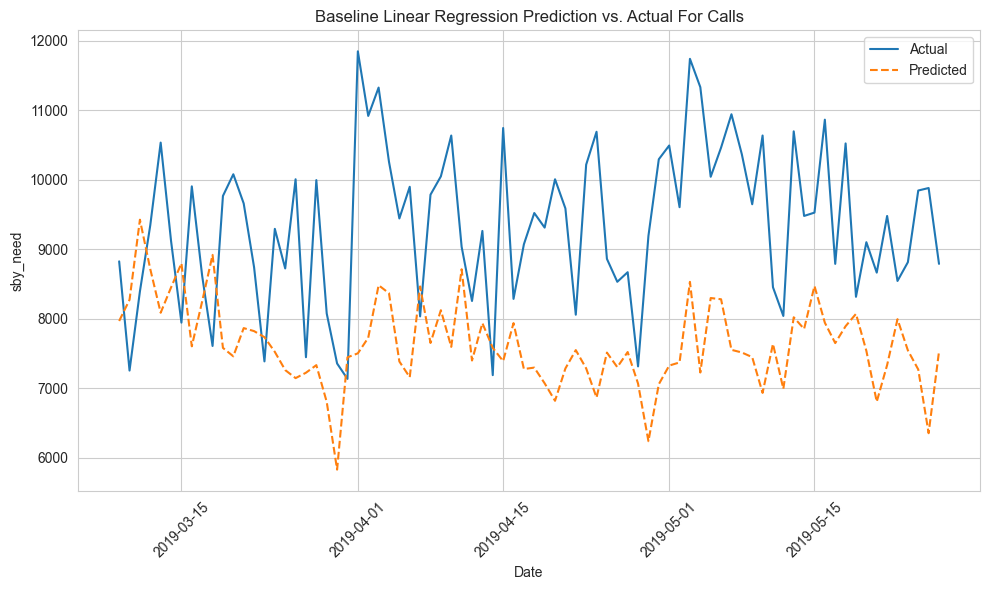

In [704]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
data = create_features(data)
data = add_lags_calls(data)

mean_calls = data['calls'].mean()
mean_sick = data['n_sick'].mean()
mean_sby = data['sby_need'].mean()
data.fillna(mean_calls, inplace=True)

features = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']

X = data[features]
y = data['calls']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=80, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

reg_model_calls = LinearRegression()

reg_model_calls.fit(X_train, y_train)

y_val_pred = reg_model_calls.predict(X_val)

rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
print(f"Validation RMSE: {rmse_val}")

y_test_pred = reg_model_calls.predict(X_test)

rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
mae = mean_absolute_error(y_test_pred, y_test)
print(mae)
print(f"Test RMSE: {rmse_test}")
calls = pd.DataFrame(y_test_pred, index=data.index[-len(y_test):])
print(reg_model_calls.coef_)

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('sby_need')
plt.title('Baseline Linear Regression Prediction vs. Actual For Calls')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Baseline Linear Regression Prediction vs. Actual for Calls.png')
plt.show()


Validation RMSE: 17.30874590333364
9.48614029415173
Test RMSE: 11.401157553326183
[ -2.75001619 -36.52486295  40.54250728   2.7984743   10.24868852
 -20.02130215]


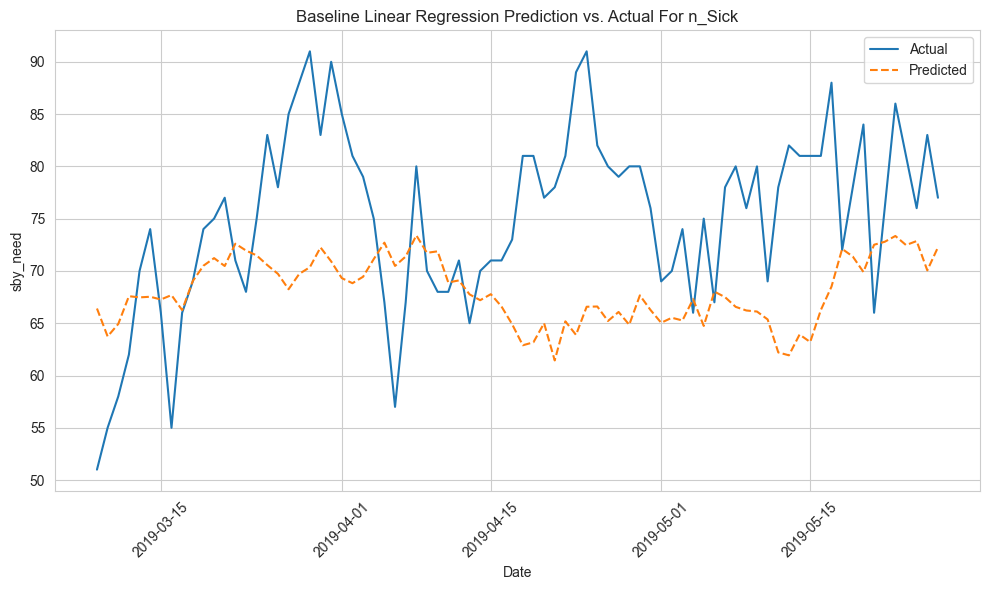

In [705]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
data = create_features(data)
data = add_lags_sick(data)
data.fillna(mean_sick, inplace=True)

features = ['dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2']

X = data[features]
y = data['n_sick']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=80, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

reg_model_calls = LinearRegression()
reg_model_calls.fit(X_train, y_train)
y_val_pred = reg_model_calls.predict(X_val)
rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
print(f"Validation RMSE: {rmse_val}")

y_test_pred = reg_model_calls.predict(X_test)
rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
mae = mean_absolute_error(y_test_pred, y_test)
print(mae)
print(f"Test RMSE: {rmse_test}")
print(reg_model_calls.coef_)
sick = pd.DataFrame(y_test_pred, index=data.index[-len(y_test):])

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('sby_need')
plt.title('Baseline Linear Regression Prediction vs. Actual For n_Sick')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Baseline Linear Regression Prediction vs. Actual for Sick.png')
plt.show()


In [688]:
sick

,0
date,
2019-03-09,68.341613
2019-03-10,66.801611
2019-03-11,69.660186
2019-03-12,69.300689
2019-03-13,70.568280
...,...
2019-05-23,74.325078
2019-05-24,75.921304
2019-05-25,73.540951


C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\371271397.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['calls'] = calls[0]
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\371271397.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['n_sick'] = sick[0]
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\371271397.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Validation RMSE: 78.20282024720674
107.94511620473072
Test RMSE: 152.52307896949944
[ 0.00000000e+00  3.71702669e-13 -2.02441937e+01 -5.13969251e+00
  7.27651544e+01 -2.29743439e+00 -1.34710600e+01  7.95588573e-01
  1.64146659e+00  0.00000000e+00]


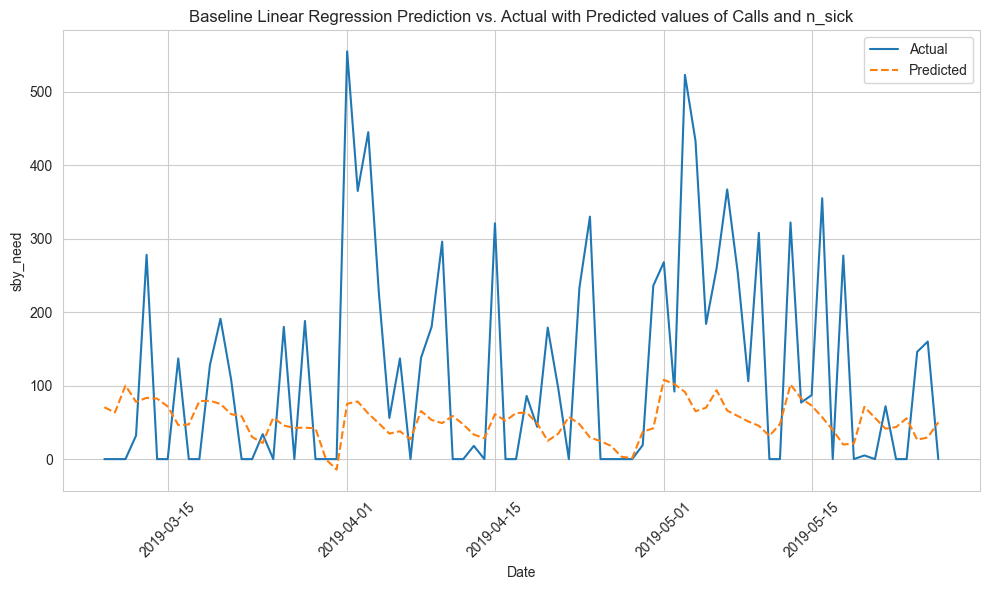

In [734]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
data = create_features(data)
data = add_lags(data)
data.fillna(mean_sby, inplace=True)


features = ['calls', 'n_sick', 'n_duty', 'dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2', 'lag3']


X = data[features]
X['calls'] = calls[0] # Comment this line to test for the test case provided, uncomment to test for predicted call input values
X['n_sick'] = sick[0] # Comment this line to test for the test case provided, uncomment to test for predicted n_sick input values
y = data['sby_need']

X.fillna(0, inplace=True) # Comment this line to test for the test case provided, uncomment to test for predicted input values

scaler = StandardScaler()
X['calls'] = scaler.fit_transform(X['calls'].values.reshape(-1, 1))
X['n_duty'] = scaler.fit_transform(X['n_duty'].values.reshape(-1, 1))
X['calls'] = scaler.fit_transform(X['calls'].values.reshape(-1, 1))
X['n_sick'] = scaler.fit_transform(X['n_sick'].values.reshape(-1, 1))



X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=80, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

reg_model = LinearRegression()


reg_model.fit(X_train, y_train)


y_val_pred = reg_model.predict(X_val)


rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
print(f"Validation RMSE: {rmse_val}")


y_test_pred = reg_model.predict(X_test)


rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
mae = mean_absolute_error(y_test_pred, y_test)
print(mae)
print(f"Test RMSE: {rmse_test}")
print(reg_model.coef_)

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('sby_need')
plt.title('Baseline Linear Regression Prediction vs. Actual with Predicted values of Calls and n_sick')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Baseline Linear Regression Prediction vs. Actual with Predicted values of Calls and n_sick.png')
plt.show()


In [736]:


# Create a DataFrame with original y and predicted y values
results_df_new = pd.DataFrame({
    'Original_y': y_test,
    'Predicted_y': y_test_pred  # Flatten the predictions array
}, index=y_test.index)

# Print the DataFrame
results_df_new

,Original_y,Predicted_y
date,,
2019-03-09,0.0,70.638124
2019-03-10,0.0,63.402155
2019-03-11,0.0,100.150209
2019-03-12,32.0,77.939883
2019-03-13,278.0,83.383041
...,...,...
2019-05-23,0.0,43.600086
2019-05-24,0.0,55.558822
2019-05-25,146.0,26.288777


C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3213102700.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['calls'] = scaler.fit_transform(X['calls'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3213102700.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['n_duty'] = scaler.fit_transform(X['n_duty'].values.reshape(-1, 1))
C:\Users\lava2\AppData\Local\Temp\ipykernel_25396\3213102700.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Validation RMSE: 56.32503010757292
82.46773254018481
Test RMSE: 120.59152672762012
[ 4.42240968e+01 -4.40202551e+00 -9.31823295e+00 -1.83062351e-01
  2.09026265e+01 -7.29022765e-01  4.97602295e+00  1.83208386e-02
 -2.69175791e-01  0.00000000e+00]


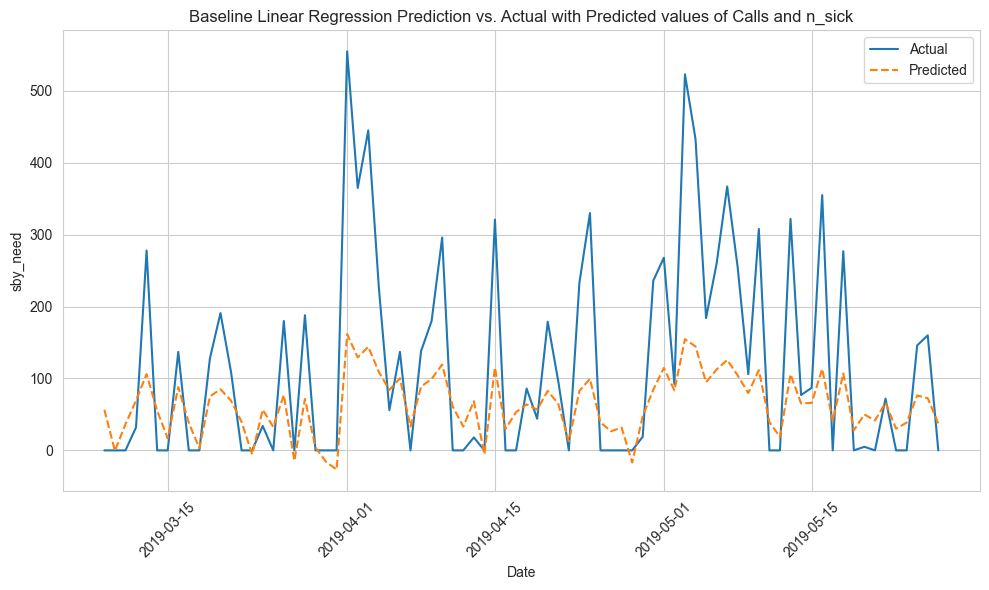

In [737]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


data = pd.read_csv('sickness_table.csv', parse_dates=['date'], index_col='date')
data = create_features(data)
data = add_lags(data)
data.fillna(mean_sby, inplace=True)


features = ['calls', 'n_sick', 'n_duty', 'dayofweek', 'month', 'dayofyear', 'quarter', 'lag1', 'lag2', 'lag3']

X = data[features]
y = data['sby_need']

scaler = StandardScaler()
X['calls'] = scaler.fit_transform(X['calls'].values.reshape(-1, 1))
X['n_duty'] = scaler.fit_transform(X['n_duty'].values.reshape(-1, 1))
X['calls'] = scaler.fit_transform(X['calls'].values.reshape(-1, 1))
X['n_sick'] = scaler.fit_transform(X['n_sick'].values.reshape(-1, 1))




X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=80, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)

reg_model = LinearRegression()


reg_model.fit(X_train, y_train)


y_val_pred = reg_model.predict(X_val)


rmse_val = np.sqrt(np.mean((y_val_pred - y_val)**2))
print(f"Validation RMSE: {rmse_val}")

y_test_pred = reg_model.predict(X_test)


rmse_test = np.sqrt(np.mean((y_test_pred - y_test)**2))
mae = mean_absolute_error(y_test_pred, y_test)
print(mae)
print(f"Test RMSE: {rmse_test}")
print(reg_model.coef_)

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('sby_need')
plt.title('Baseline Linear Regression Prediction vs. Actual with Predicted values of Calls and n_sick')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Baseline Linear Regression Prediction vs. Actual with Predicted values of Calls and n_sick.png')
plt.show()


In [738]:
# Create a DataFrame with original y and predicted y values
results_df = pd.DataFrame({
    'Original_y': y_test,
    'Predicted_y': y_test_pred  # Flatten the predictions array
}, index=y_test.index)

# Print the DataFrame
results_df

,Original_y,Predicted_y
date,,
2019-03-09,0.0,56.512526
2019-03-10,0.0,-0.767661
2019-03-11,0.0,36.428324
2019-03-12,32.0,69.424282
2019-03-13,278.0,106.166081
...,...,...
2019-05-23,0.0,30.130838
2019-05-24,0.0,38.623809
2019-05-25,146.0,76.291174


In [739]:
artest = activation_rate_metric(results_df)
intest = insufficient_standbys_metric(results_df)
ar_new = activation_rate_metric(results_df_new)
in_new = insufficient_standbys_metric(results_df_new)
ar_orig = activation_rate_metric(comparison_df)
in_orig = insufficient_standbys_metric(comparison_df)
print('Activation rate for test', artest)
print('Insuff sby rate for test',intest)
print('Activation rate for pred',ar_new)
print('Insuff sby rate for pred',in_new)
print('Activation rate for Original',ar_orig)
print('Insuff sby rate for Original',in_orig)

Activation rate for test 128.34820126543315
Insuff sby rate for test 58.75
Activation rate for pred 207.08904475860302
Insuff sby rate for pred 52.5
Activation rate for Original 127.69444444444444
Insuff sby rate for Original 45.0
